In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms
from mpl_toolkits.mplot3d import Axes3D
from ase.data import chemical_symbols
import random
import numpy as np
import os
import pandas as pd
import numpy as np
from ase.io import read
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import read
from ase.data import chemical_symbols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import pandas as pd

2025-06-25 15:05:25.502130: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 15:05:25.509602: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 15:05:26.338073: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 15:05:29.805377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 15:05:31.826192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# Energies dataframe

In [2]:
# Path setup
data_dir = "./"  # <-- Change this to your actual data path
atoms_train_dir = os.path.join(data_dir, "atoms", "train")
energies_csv = os.path.join(data_dir, "energies", "train.csv")
energies_df = pd.read_csv(energies_csv)
energies_df["id"] = energies_df["id"].astype(str)
energies_df = energies_df.sort_values("id")

# Extract features

In [3]:
def extract_features(xyz_path):
    atoms = read(xyz_path)
    positions = atoms.get_positions()
    charges = atoms.get_atomic_numbers()
    return positions, charges

def load_all_xyz(folder_path, max_atoms=23):
    positions_list = []
    charges_list = []
    
    xyz_files = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith('.xyz')
    ])

    for xyz_path in xyz_files:
        pos, chg = extract_features(xyz_path)
        
        pos_padded = np.zeros((max_atoms, 3))
        chg_padded = np.zeros((max_atoms,))
        
        n_atoms = pos.shape[0]
        pos_padded[:n_atoms, :] = pos
        chg_padded[:n_atoms] = chg

        positions_list.append(pos_padded)
        charges_list.append(chg_padded)

    positions_array = np.stack(positions_list)  # shape (N, max_atoms, 3)
    charges_array = np.stack(charges_list)      # shape (N, max_atoms)
    
    return positions_array, charges_array

In [4]:
pos, full_charges = load_all_xyz("./atoms/train/", max_atoms=23)
n_molecules = pos.shape[0]

# Some visualization

# 2D

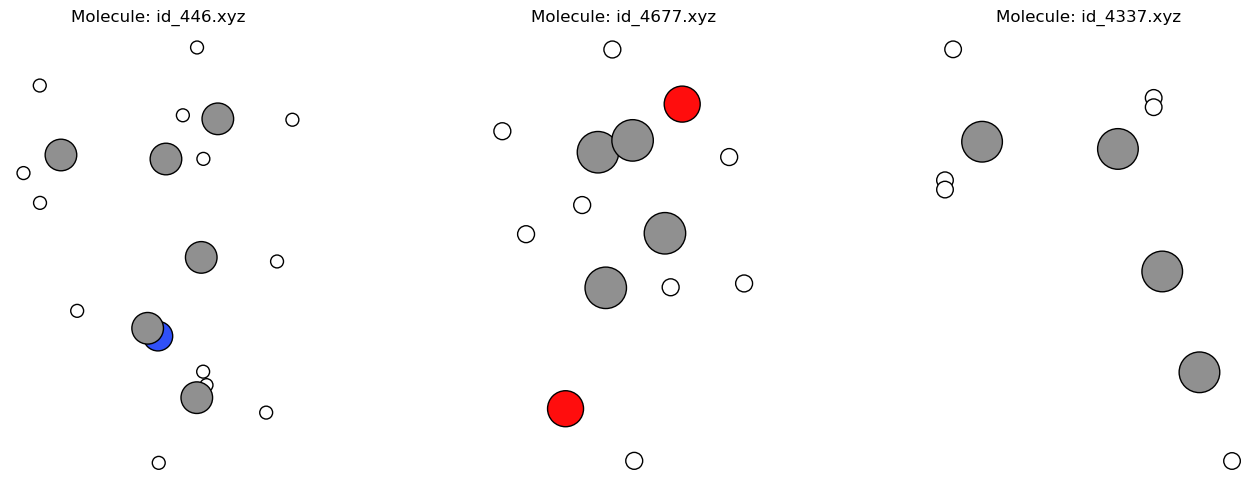

In [5]:
sample_files = random.sample(sorted(os.listdir(atoms_train_dir)), 3)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

for ax, fname in zip(axs, sample_files):
    atoms = read(os.path.join(atoms_train_dir, fname))
    plot_atoms(atoms, ax, radii=0.3)
    ax.set_title(f"Molecule: {fname}")
    ax.axis('off')

plt.tight_layout()  
plt.show()

## 3D

In [6]:
def visualize_molecule_3d(positions, charges, idx=0):
    pos = positions[idx]
    chg = charges[idx]

    mask = chg > 0
    pos = pos[mask]
    chg = chg[mask]

    # Define chemical symbols and color map
    chemical_symbols = {
        1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 16: 'S', 17: 'Cl'
    }

    symbols = [chemical_symbols.get(int(z), 'Unknown') for z in chg]

    color_map = {
        'H': 'white', 'C': 'gray', 'N': 'blue', 'O': 'red',
        'F': 'green', 'S': 'yellow', 'Cl': 'lime'
    }

    colors = [color_map.get(sym, 'gray') for sym in symbols]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=pos[:, 0],
        y=pos[:, 1],
        z=pos[:, 2],
        mode='markers+text',
        marker=dict(
            size=10,
            color=colors,
            opacity=0.8
        ),
        text=symbols,
        textfont=dict(size=12),
        hoverinfo='text',
        textposition="middle center"
    ))

    fig.update_layout(
        title=f"3D Molecule #{idx}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    fig.show()

visualize_molecule_3d(pos, full_charges, idx=4029)

# Display rolled molecules

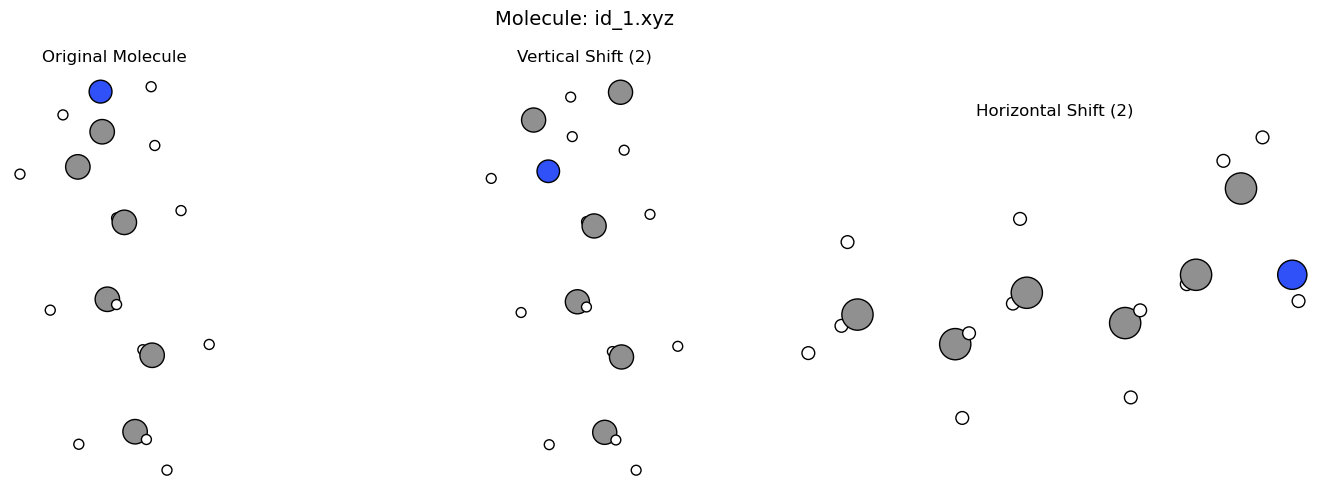

In [7]:
def display_rolled_molecule(atoms_train_dir, num_molecule, shift=2):
    """
    Display the original molecule and its vertically and horizontally shifted versions.
    """
    molecule_file = sorted(os.listdir(atoms_train_dir))[num_molecule]
    atoms = read(os.path.join(atoms_train_dir, molecule_file))

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Molecule: {molecule_file}", fontsize=14)

    # Original molecule
    ax1 = plt.subplot(1, 3, 1)
    plot_atoms(atoms, ax1, radii=0.3)
    ax1.set_title("Original Molecule")
    ax1.axis('off')

    # Vertically shifted molecule
    ax2 = plt.subplot(1, 3, 2)
    positions = atoms.get_positions()
    shifted_positions_v = np.roll(positions, shift, axis=0)
    atoms.set_positions(shifted_positions_v)
    plot_atoms(atoms, ax2, radii=0.3)
    ax2.set_title(f"Vertical Shift ({shift})")
    ax2.axis('off')

    # Horizontally shifted molecule
    ax3 = plt.subplot(1, 3, 3)
    shifted_positions_h = np.roll(positions, shift, axis=1)
    atoms.set_positions(shifted_positions_h)
    plot_atoms(atoms, ax3, radii=0.3)
    ax3.set_title(f"Horizontal Shift ({shift})")
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

display_rolled_molecule(atoms_train_dir, num_molecule=0, shift=2)

# Understand the data

## Utility functions

In [8]:
def compute_num_atoms(charges):
    return np.count_nonzero(charges, axis=1)

def compute_avg_atomic_number(charges):
    nonzero = charges != 0
    return np.sum(charges, axis=1) / np.sum(nonzero, axis=1)

def compute_centroid_distances(positions, charges):
    distances = []
    for pos, chg in zip(positions, charges):
        mask = chg != 0
        valid_pos = pos[mask]
        if len(valid_pos) > 0:
            centroid = valid_pos.mean(axis=0)
            dists = np.linalg.norm(valid_pos - centroid, axis=1)
            distances.append(dists.mean())
        else:
            distances.append(0.0)
    return np.array(distances)

def flatten_atomic_numbers(charges):
    return charges[charges != 0]

In [9]:
num_atoms = compute_num_atoms(full_charges)
avg_Z = compute_avg_atomic_number(full_charges)
mean_distances = compute_centroid_distances(pos, full_charges)
all_Z = flatten_atomic_numbers(full_charges)
xy_weighted = np.concatenate([
    np.repeat([pos[i][full_charges[i] != 0, :2]], full_charges[i][full_charges[i] != 0].astype(int), axis=1)[0]
    for i in range(n_molecules)
])

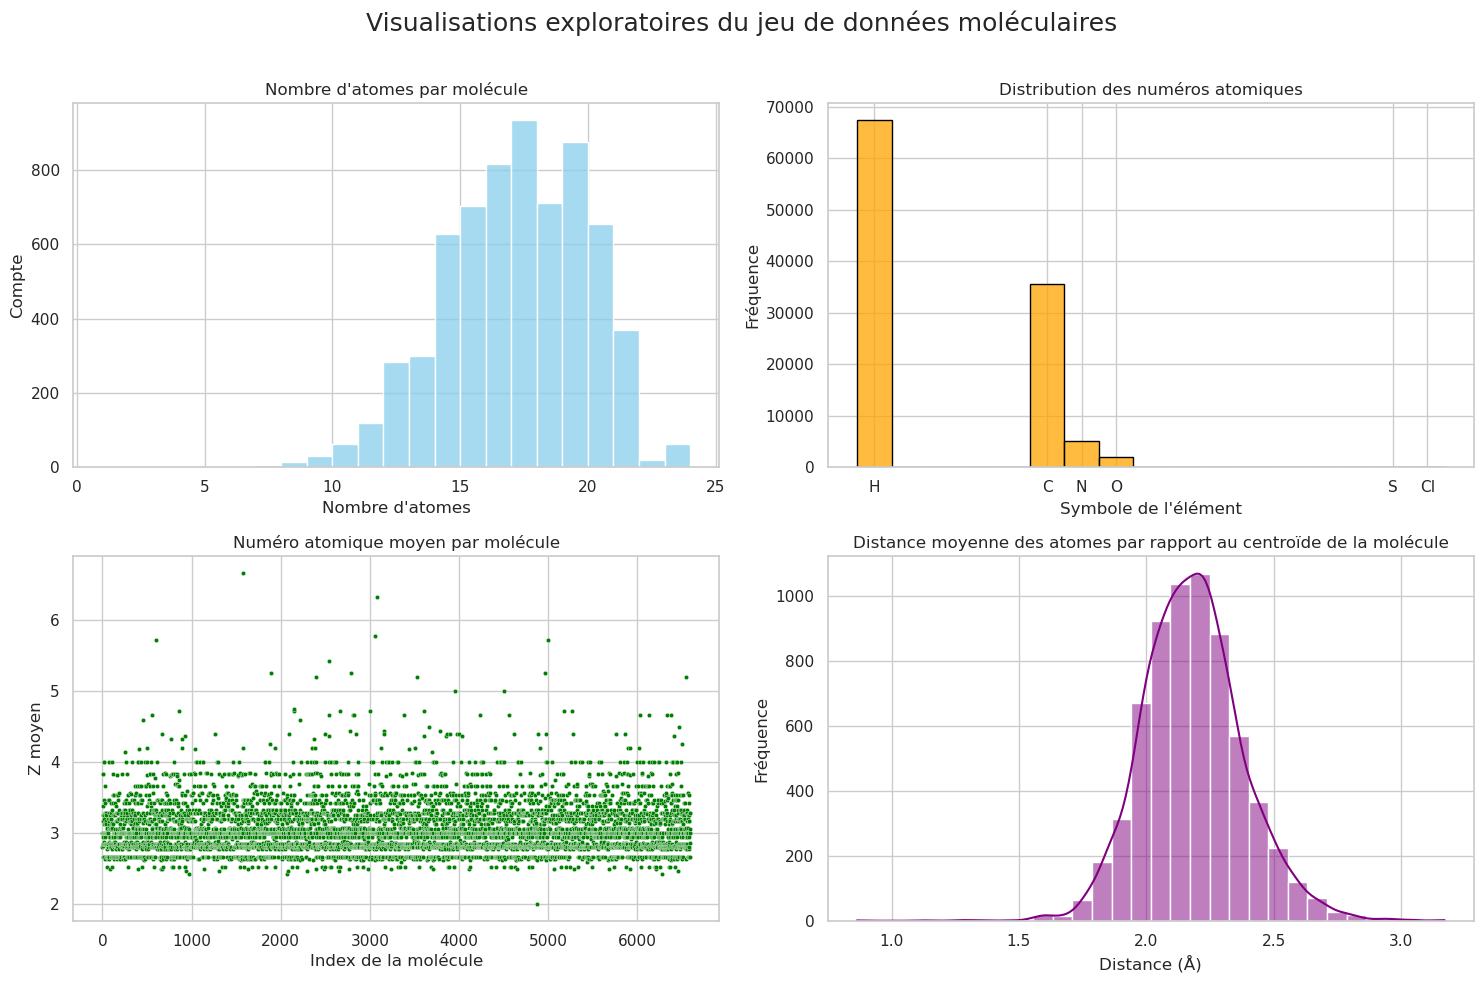

In [10]:
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Visualisations exploratoires du jeu de données moléculaires", fontsize=18)

sns.histplot(num_atoms, bins=range(1, 25), kde=False, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Nombre d'atomes par molécule")
axs[0, 0].set_xlabel("Nombre d'atomes")
axs[0, 0].set_ylabel("Compte")

unique_Z = np.unique(all_Z)
bins = np.arange(1, all_Z.max() + 2) - 0.5
sns.histplot(all_Z, bins=bins, ax=axs[0, 1], color='orange', edgecolor='black')
axs[0, 1].set_xticks(unique_Z)
axs[0, 1].set_xticklabels([f"{chemical_symbols[int(Z)]}" for Z in unique_Z])
axs[0, 1].set_title("Distribution des numéros atomiques")
axs[0, 1].set_xlabel("Symbole de l'élément")
axs[0, 1].set_ylabel("Fréquence")

sns.scatterplot(x=np.arange(n_molecules), y=avg_Z, ax=axs[1, 0], color='green', s=10)
axs[1, 0].set_title("Numéro atomique moyen par molécule")
axs[1, 0].set_xlabel("Index de la molécule")
axs[1, 0].set_ylabel("Z moyen")


sns.histplot(mean_distances, bins=30, kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title("Distance moyenne des atomes par rapport au centroïde de la molécule")
axs[1, 1].set_xlabel("Distance (Å)")
axs[1, 1].set_ylabel("Fréquence")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Scattering coefficients visualization

In [11]:
order_0_train_article = np.load('/home/besbesines/kymatio_cache/results/train/order_0_molecule_L_3_J_4_sigma_2.0_MNO_(96, 64, 48)_powers_[0.5, 1.0, 2.0, 3.0, 4.0].npy')
orders_1_and_2_train_article = np.load('/home/besbesines/kymatio_cache/results/train/orders_1_and_2molecule_L_3_J_4_sigma_2.0_MNO_(96, 64, 48)_powers_[0.5, 1.0, 2.0, 3.0, 4.0].npy')
X = np.concatenate([order_0_train_article, orders_1_and_2_train_article], axis=1)
y = energies_df['energy'].to_list()


In [28]:
X.shape

(6591, 1220)

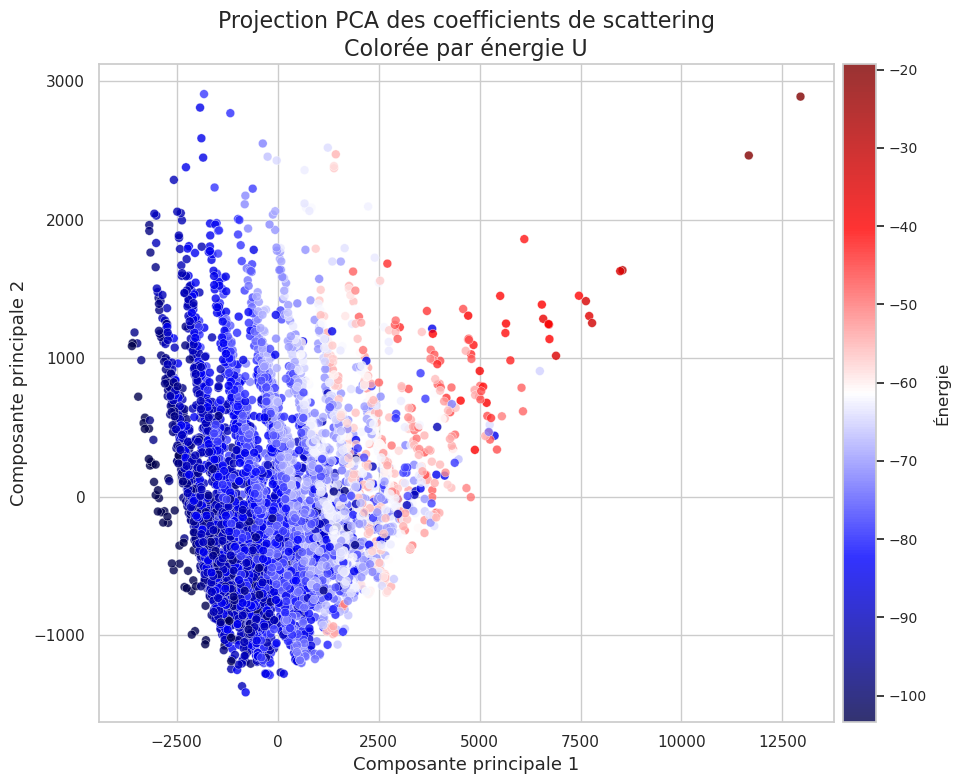

In [21]:
sns.set(style="whitegrid")

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], 
    c=y, cmap='seismic', 
    s=40, alpha=0.8, edgecolors='w', linewidth=0.3
)

plt.title("Projection PCA des coefficients de scattering\nColorée par énergie U", fontsize=16)
plt.xlabel("Composante principale 1", fontsize=13)
plt.ylabel("Composante principale 2", fontsize=13)
cbar = plt.colorbar(sc, pad=0.01)
cbar.set_label("Énergie", fontsize=12)
cbar.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


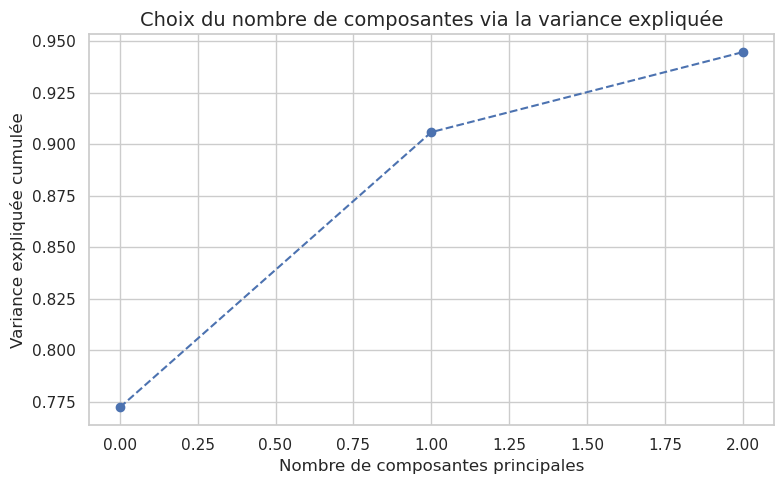

In [22]:
# Courbe de la variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Nombre de composantes principales", fontsize=12)
plt.ylabel("Variance expliquée cumulée", fontsize=12)
plt.title("Choix du nombre de composantes via la variance expliquée", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
print(np.corrcoef(X_pca[:, 3], y)[0, 1])  # Corrélation entre PC1 et énergie
print(np.corrcoef(X_pca[:, 4], y)[0, 1])  # PC2 et énergie

-0.1193685400761515
-0.4369534183209285


(6591, 20)
(6591, 1200)


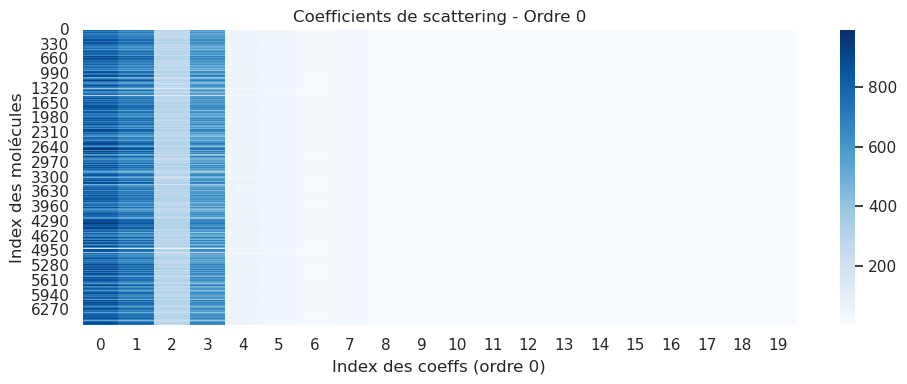

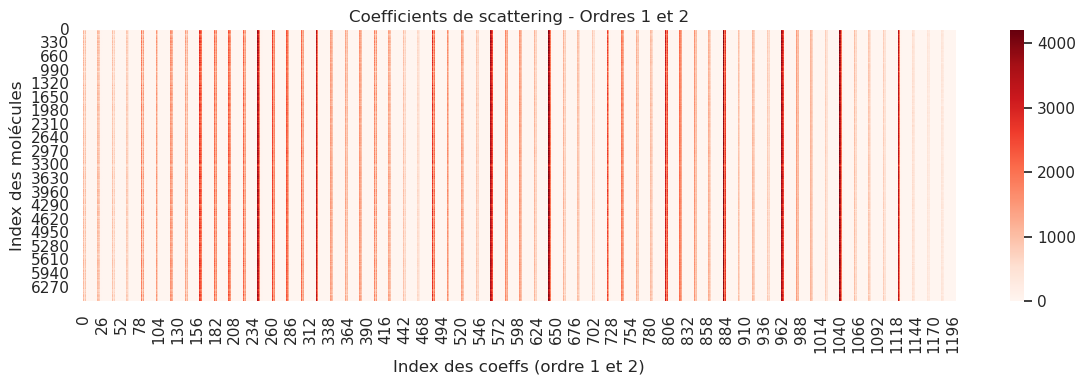

In [30]:
print(order_0_train_article.shape)      
print(orders_1_and_2_train_article.shape)  

# Heatmap ordre 0
plt.figure(figsize=(10, 4))
sns.heatmap(order_0_train_article, cmap="Blues")
plt.title("Coefficients de scattering - Ordre 0")
plt.xlabel("Index des coeffs (ordre 0)")
plt.ylabel("Index des molécules")
plt.tight_layout()
plt.show()

# Heatmap ordres 1 et 2
plt.figure(figsize=(12, 4))
sns.heatmap(orders_1_and_2_train_article, cmap="Reds")
plt.title("Coefficients de scattering - Ordres 1 et 2")
plt.xlabel("Index des coeffs (ordre 1 et 2)")
plt.ylabel("Index des molécules")
plt.tight_layout()
plt.show()

1. Invariance to indexation of the atoms in the state x;
2. Invariance to rigid motion of the state x; 

Indeed, invariance properties reduce the dimensionality of the approximation. 